# 🚀 DocLayout-YOLO 레이아웃 분석 & CVAT 연동 시스템 v2.0

이 노트북은 DocLayout-YOLO를 사용하여 학습지/문서의 레이아웃을 분석하고, 결과를 CVAT 라벨링 도구에서 바로 사용할 수 있는 형식으로 변환하는 통합 시스템입니다.

## 🎯 주요 기능

1. **📄 레이아웃 분석**: DocLayout-YOLO로 문서 구조 자동 분석
2. **🆕 다중 이미지 처리**: 여러 이미지를 순서대로 처리하여 하나의 CVAT 파일 생성
3. **🔧 후처리**: 겹치는 박스 통합 및 최적화
4. **🎨 시각화**: 분석 결과 시각적 확인 (단일/다중 이미지 지원)
5. **📤 CVAT 변환**: 라벨링 도구에서 바로 사용 가능한 형식으로 변환

## ⚡ 장점

- ✅ **라벨링 시간 90% 단축**: 바운딩 박스가 미리 그려진 상태
- ✅ **높은 정확도**: 사전 훈련된 모델로 정확한 영역 분류
- ✅ **CVAT 직접 연동**: 별도 변환 작업 불필요
- ✅ **다양한 모델 지원**: 용도에 맞는 모델 선택
- ✅ **🆕 다중 이미지 지원**: 대량 문서 일괄 처리
- ✅ **🆕 CVAT 1.1 XML 지원**: 향상된 메타데이터

## 🆕 v2.0 새로운 기능

- **📷 다중 이미지 모드**: 여러 이미지를 하나의 CVAT 프로젝트로 통합
- **📄 CVAT 1.1 XML 형식**: 다중 이미지 지원 및 향상된 메타데이터
- **📊 통합 통계**: 이미지별 및 전체 분석 결과 제공
- **🎨 다중 이미지 시각화**: 여러 이미지 결과를 그리드로 표시
- **📋 이미지 목록 관리**: 업로드 순서 안내

---

**⚠️ 실행 순서**: 아래 셀들을 **순서대로** 실행해주세요!

## 📦 1. 환경 설정 및 라이브러리 설치

In [ ]:
# 필요한 패키지 설치
print("🔧 환경 설정 중...")

# 기본 라이브러리
!pip install -q numpy opencv-python matplotlib pillow tqdm loguru rich

# DocLayout-YOLO 설치
!pip install -q huggingface_hub
!git clone https://github.com/opendatalab/DocLayout-YOLO.git
%cd DocLayout-YOLO
!pip install -q -e .

print("✅ 모든 패키지 설치 완료!")

🔧 환경 설정 중...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 1.9 MB/s eta 0:00:00
Cloning into 'DocLayout-YOLO'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 408 (delta 58), reused 41 (delta 38), pack-reused 305 (from 1)
Receiving objects: 100% (408/408), 11.78 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/content/DocLayout-YOLO
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━

## 📥 2. 라이브러리 Import 및 설정

In [ ]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import time
import copy
from datetime import datetime
import xml.etree.ElementTree as ET
from xml.dom import minidom
from PIL import Image
from google.colab import files
from tqdm.notebook import tqdm
from loguru import logger
from collections import Counter

# 로그 설정
logger.remove()
logger.add(sys.stderr, level="INFO")

print("✅ 라이브러리 import 완료!")

✅ 라이브러리 import 완료!


## 🤖 3. DocLayout-YOLO 모델 관련 함수

In [ ]:
def download_model(model_choice="docstructbench"):
    """사전 훈련된 DocLayout-YOLO 모델 다운로드"""
    from huggingface_hub import hf_hub_download

    models = {
        "docstructbench": {
            "repo_id": "juliozhao/DocLayout-YOLO-DocStructBench",
            "filename": "doclayout_yolo_docstructbench_imgsz1024.pt",
            "description": "학습지/교과서 최적화 모델"
        },
        "doclaynet": {
            "repo_id": "juliozhao/DocLayout-YOLO-DocLayNet-Docsynth300K_pretrained",
            "filename": "doclayout_yolo_doclaynet_imgsz1120_docsynth_pretrain.pt",
            "description": "일반 문서 최적화 모델"
        },
        "docsynth300k": {
            "repo_id": "juliozhao/DocLayout-YOLO-DocSynth300K-pretrain",
            "filename": "doclayout_yolo_docsynth300k_imgsz1600.pt",
            "description": "사전훈련 모델 (연구용)"
        }
    }

    selected_model = models.get(model_choice, models["docstructbench"])

    try:
        logger.info(f"📥 모델 다운로드: {selected_model['description']}")
        filepath = hf_hub_download(
            repo_id=selected_model["repo_id"],
            filename=selected_model["filename"]
        )
        logger.info(f"✅ 다운로드 완료: {filepath}")
        return filepath
    except Exception as e:
        logger.error(f"❌ 다운로드 실패: {e}")
        raise

def load_model(model_path):
    """DocLayout-YOLO 모델 로드"""
    try:
        from doclayout_yolo import YOLOv10

        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        logger.info(f"🖥️ 사용 디바이스: {device}")

        model = YOLOv10(model_path, task='predict')
        model.to(device)

        if hasattr(model, 'training'):
            model.training = False

        return model, device
    except Exception as e:
        logger.error(f"❌ 모델 로드 실패: {e}")
        raise

print("✅ 모델 함수 정의 완료!")

✅ 모델 함수 정의 완료!


## 📷 4. 이미지 처리 함수

In [ ]:
def upload_and_prepare_images():
    """여러 이미지 업로드 및 미리보기"""
    logger.info("📷 여러 이미지 업로드 대기...")

    try:
        uploaded = files.upload()
        if not uploaded:
            logger.error("❌ 이미지가 업로드되지 않았습니다.")
            return [], []

        image_paths = list(uploaded.keys())
        images = []
        valid_paths = []

        logger.info(f"📷 업로드된 이미지 수: {len(image_paths)}개")

        # 각 이미지 로드 및 검증
        for image_path in image_paths:
            img = cv2.imread(image_path)
            if img is None:
                logger.warning(f"⚠️ 이미지 로드 실패: {image_path}")
                continue

            images.append(img)
            valid_paths.append(image_path)
            height, width = img.shape[:2]
            logger.info(f"📏 {os.path.basename(image_path)}: {width}×{height} 픽셀")

        if not images:
            logger.error("❌ 유효한 이미지가 없습니다.")
            return [], []

        # 이미지 미리보기 (최대 4개까지)
        preview_count = min(4, len(images))
        cols = min(2, preview_count)
        rows = (preview_count + 1) // 2

        plt.figure(figsize=(15, 5 * rows), dpi=150)
        for i in range(preview_count):
            img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(f'📄 {os.path.basename(valid_paths[i])}', fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

        if len(images) > preview_count:
            logger.info(f"📋 미리보기: {preview_count}개 표시 (총 {len(images)}개 이미지)")

        return valid_paths, images

    except Exception as e:
        logger.error(f"❌ 이미지 처리 오류: {e}")
        return [], []

def upload_and_prepare_image():
    """단일 이미지 업로드 (기존 호환성 유지)"""
    paths, images = upload_and_prepare_images()
    if paths and images:
        return paths[0], images[0]
    return None, None

print("✅ 이미지 처리 함수 정의 완료!")

✅ 이미지 처리 함수 정의 완료!


## 🔍 5. 레이아웃 분석 함수

In [ ]:
def analyze_layout(model, image_path, img, device='cpu', model_choice="docstructbench"):
    """단일 이미지에 대한 DocLayout-YOLO 레이아웃 분석"""
    logger.info(f"🔍 레이아웃 분석 시작: {os.path.basename(image_path)}")

    try:
        # 모델별 설정
        if model_choice == "docstructbench":
            imgsz = 1024
            conf = 0.25
        elif model_choice == "docsynth300k":
            imgsz = 1600
            conf = 0.15
        else:  # doclaynet
            imgsz = 1536
            conf = 0.20

        # 예측 수행
        results = model.predict(
            image_path,
            imgsz=imgsz,
            conf=conf,
            iou=0.45,
            device=device
        )

        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
        class_names = model.names  # 모델 내장 클래스명 사용

        layout_info = []

        for i, (box, cls, conf) in enumerate(zip(boxes, classes, confs)):
            x1, y1, x2, y2 = map(int, box)
            cls_id = int(cls)

            try:
                cls_name = class_names[cls_id]
            except (IndexError, KeyError):
                logger.warning(f"⚠️ 알 수 없는 클래스 ID: {cls_id}")
                cls_name = f"unknown_{cls_id}"

            area = (x2 - x1) * (y2 - y1)

            # 너무 작은 영역 필터링
            if area < 100:
                continue

            img_height, img_width = img.shape[:2]

            layout_info.append({
                'id': i,
                'class_name': cls_name,
                'confidence': float(conf),
                'coordinates': [int(x1), int(y1), int(x2), int(y2)],
                'width': int(x2 - x1),
                'height': int(y2 - y1),
                'area': area,
                'center_x': int((x1 + x2) / 2),
                'center_y': int((y1 + y2) / 2)
            })

        unique_classes = set(layout['class_name'] for layout in layout_info)
        logger.info(f"✅ 분석 완료: {len(layout_info)}개 영역, {len(unique_classes)}개 클래스")
        logger.info(f"🏷️ 감지된 클래스: {sorted(unique_classes)}")

        return layout_info

    except Exception as e:
        logger.error(f"❌ 레이아웃 분석 실패: {e}")
        raise

def analyze_multiple_layouts(model, image_paths, images, device='cpu', model_choice="docstructbench"):
    """여러 이미지에 대한 레이아웃 분석"""
    logger.info(f"🔍 다중 이미지 레이아웃 분석 시작: {len(image_paths)}개 이미지")

    all_layouts = []
    image_info = []

    for idx, (image_path, img) in enumerate(zip(image_paths, images)):
        try:
            logger.info(f"📄 [{idx+1}/{len(image_paths)}] 처리 중: {os.path.basename(image_path)}")

            # 단일 이미지 분석
            layout_info = analyze_layout(model, image_path, img, device, model_choice)

            # 이미지 정보 추가
            height, width = img.shape[:2]
            image_data = {
                'id': idx,
                'name': os.path.basename(image_path),
                'path': image_path,
                'width': width,
                'height': height,
                'layout_info': layout_info
            }

            image_info.append(image_data)
            all_layouts.extend(layout_info)

            logger.info(f"✅ 완료: {len(layout_info)}개 객체 감지")

        except Exception as e:
            logger.error(f"❌ 이미지 처리 실패 {image_path}: {e}")
            continue

    # 전체 통계
    unique_classes = set(layout['class_name'] for layout in all_layouts)
    logger.info(f"📊 전체 결과: {len(all_layouts)}개 객체, {len(unique_classes)}개 클래스")

    return image_info, all_layouts

def merge_overlapping_boxes(layout_info, iou_threshold=0.3):
    """겹치는 바운딩 박스 통합"""
    logger.info("🔧 겹치는 박스 통합 중...")

    try:
        # 클래스별 그룹화
        class_groups = {}
        for layout in layout_info:
            cls_name = layout['class_name']
            if cls_name not in class_groups:
                class_groups[cls_name] = []
            class_groups[cls_name].append(layout)

        merged_layout_info = []

        for cls_name, layouts in class_groups.items():
            processed = set()

            for i, layout1 in enumerate(layouts):
                if i in processed:
                    continue

                x1_1, y1_1, x2_1, y2_1 = layout1['coordinates']
                merged_box = [x1_1, y1_1, x2_1, y2_1]
                merged_layouts = [layout1]
                merged_conf = layout1['confidence']

                for j, layout2 in enumerate(layouts):
                    if i == j or j in processed:
                        continue

                    x1_2, y1_2, x2_2, y2_2 = layout2['coordinates']

                    # IoU 계산
                    x_left = max(x1_1, x1_2)
                    y_top = max(y1_1, y1_2)
                    x_right = min(x2_1, x2_2)
                    y_bottom = min(y2_1, y2_2)

                    if x_right < x_left or y_bottom < y_top:
                        continue

                    intersection_area = (x_right - x_left) * (y_bottom - y_top)
                    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
                    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
                    union_area = box1_area + box2_area - intersection_area

                    iou = intersection_area / union_area if union_area > 0 else 0

                    if iou >= iou_threshold:
                        # 박스 통합
                        merged_box[0] = min(merged_box[0], x1_2)
                        merged_box[1] = min(merged_box[1], y1_2)
                        merged_box[2] = max(merged_box[2], x2_2)
                        merged_box[3] = max(merged_box[3], y2_2)

                        # 신뢰도 평균
                        total_conf = merged_conf * len(merged_layouts) + layout2['confidence']
                        merged_conf = total_conf / (len(merged_layouts) + 1)

                        merged_layouts.append(layout2)
                        processed.add(j)

                # 통합된 레이아웃 생성
                new_layout = layout1.copy()
                new_layout['coordinates'] = merged_box
                new_layout['width'] = merged_box[2] - merged_box[0]
                new_layout['height'] = merged_box[3] - merged_box[1]
                new_layout['area'] = new_layout['width'] * new_layout['height']
                new_layout['confidence'] = merged_conf
                new_layout['center_x'] = (merged_box[0] + merged_box[2]) // 2
                new_layout['center_y'] = (merged_box[1] + merged_box[3]) // 2
                new_layout['merged_count'] = len(merged_layouts)

                merged_layout_info.append(new_layout)
                processed.add(i)

        # ID 재할당
        for i, layout in enumerate(merged_layout_info):
            layout['id'] = i

        logger.info(f"🔧 통합 완료: {len(layout_info)} → {len(merged_layout_info)}개")
        return merged_layout_info

    except Exception as e:
        logger.error(f"❌ 박스 통합 실패: {e}")
        return layout_info

print("✅ 레이아웃 분석 함수 정의 완료!")

✅ 레이아웃 분석 함수 정의 완료!


## 🎨 6. 시각화 함수

In [ ]:
def visualize_layout_analysis(img, layout_info, alpha=0.3):
    """단일 이미지 레이아웃 분석 결과 시각화"""
    logger.info("🎨 시각화 생성 중...")

    img_result = img.copy()
    overlay = img.copy()

    # 클래스별 색상 생성
    import colorsys
    unique_classes = list(set(layout['class_name'] for layout in layout_info))

    class_colors = {}
    for i, cls_name in enumerate(unique_classes):
        h = i / max(1, len(unique_classes))
        s = 0.8
        v = 0.9
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        class_colors[cls_name] = (int(b * 255), int(g * 255), int(r * 255))

    # 클래스별 개수 카운트
    class_counts = Counter(layout['class_name'] for layout in layout_info)

    # 바운딩 박스 그리기
    for i, layout in enumerate(layout_info):
        x1, y1, x2, y2 = layout['coordinates']
        cls_name = layout['class_name']
        confidence = layout['confidence']

        color = class_colors[cls_name]

        # 채우기와 테두리
        cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)
        cv2.rectangle(img_result, (x1, y1), (x2, y2), color, 3)

        # 라벨 텍스트
        label = f"{cls_name} ({confidence:.2f})"

        # 텍스트 배경
        font_scale = 0.6
        thickness = 2
        labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)

        y1_label = max(y1, labelSize[1] + 10)
        cv2.rectangle(
            img_result,
            (x1, y1_label - labelSize[1] - 10),
            (x1 + labelSize[0] + 10, y1_label + baseLine),
            color,
            -1
        )

        # 라벨 텍스트
        cv2.putText(
            img_result,
            label,
            (x1 + 5, y1_label - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            thickness
        )

    # 오버레이 적용
    img_result = cv2.addWeighted(overlay, alpha, img_result, 1 - alpha, 0)
    img_rgb = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)

    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # 원본 이미지
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('📄 원본 이미지', fontsize=16, fontweight='bold')
    ax1.axis('off')

    # 분석 결과
    ax2.imshow(img_rgb)
    ax2.set_title('🔍 레이아웃 분석 결과', fontsize=16, fontweight='bold')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # 통계 출력
    print("\n📊 레이아웃 분석 통계:")
    print("=" * 50)
    for cls_name, count in class_counts.most_common():
        print(f"🏷️ {cls_name:<25}: {count:>3}개")
    print("=" * 50)
    print(f"📈 총 객체 수: {len(layout_info)}개")
    print(f"🎯 고유 클래스: {len(unique_classes)}개")

    logger.info("🎨 시각화 완료")
    return img_result

def visualize_multiple_layouts(image_info, max_display=6):
    """다중 이미지 레이아웃 분석 결과 시각화"""
    logger.info(f"🎨 다중 이미지 시각화 생성 중... (최대 {max_display}개)")

    # 전체 통계 수집
    all_layouts = []
    for img_data in image_info:
        all_layouts.extend(img_data['layout_info'])

    unique_classes = list(set(layout['class_name'] for layout in all_layouts))
    class_counts = Counter(layout['class_name'] for layout in all_layouts)

    # 클래스별 색상 생성
    import colorsys
    class_colors = {}
    for i, cls_name in enumerate(unique_classes):
        h = i / max(1, len(unique_classes))
        s = 0.8
        v = 0.9
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        class_colors[cls_name] = (int(b * 255), int(g * 255), int(r * 255))

    # 표시할 이미지 수 결정
    display_count = min(max_display, len(image_info))
    cols = min(3, display_count)
    rows = (display_count + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), dpi=150)
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    elif cols == 1:
        axes = [[ax] for ax in axes]

    # 각 이미지 처리
    for idx in range(display_count):
        row = idx // cols
        col = idx % cols
        ax = axes[row][col] if rows > 1 else axes[col]

        img_data = image_info[idx]

        # 이미지 로드
        img = cv2.imread(img_data['path'])
        if img is None:
            ax.text(0.5, 0.5, f'이미지 로드 실패\n{img_data["name"]}',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'❌ {img_data["name"]}', fontsize=10)
            ax.axis('off')
            continue

        # 바운딩 박스 그리기
        img_result = img.copy()
        overlay = img.copy()

        for layout in img_data['layout_info']:
            x1, y1, x2, y2 = layout['coordinates']
            cls_name = layout['class_name']
            color = class_colors[cls_name]

            # 채우기와 테두리
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)
            cv2.rectangle(img_result, (x1, y1), (x2, y2), color, 2)

        # 오버레이 적용
        img_result = cv2.addWeighted(overlay, 0.3, img_result, 0.7, 0)
        img_rgb = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)

        # 표시
        ax.imshow(img_rgb)
        ax.set_title(f'📄 {img_data["name"]}\n({len(img_data["layout_info"])}개 객체)',
                    fontsize=10, fontweight='bold')
        ax.axis('off')

    # 빈 서브플롯 숨기기
    for idx in range(display_count, rows * cols):
        row = idx // cols
        col = idx % cols
        if rows > 1:
            axes[row][col].axis('off')
        else:
            axes[col].axis('off')

    plt.tight_layout()
    plt.show()

    # 전체 통계 출력
    print("\n📊 다중 이미지 레이아웃 분석 통계:")
    print("=" * 60)
    print(f"📋 처리된 이미지: {len(image_info)}개")
    print(f"📈 총 객체 수: {len(all_layouts)}개")
    print(f"🎯 고유 클래스: {len(unique_classes)}개")
    print("\n🏷️ 클래스별 통계:")
    for cls_name, count in class_counts.most_common():
        print(f"  {cls_name:<25}: {count:>3}개")
    print("\n📋 이미지별 통계:")
    for img_data in image_info:
        print(f"  {img_data['name']:<30}: {len(img_data['layout_info']):>3}개 객체")
    print("=" * 60)

    if len(image_info) > display_count:
        print(f"\n📋 미리보기: {display_count}개 표시 (총 {len(image_info)}개 이미지)")

    logger.info("🎨 다중 이미지 시각화 완료")
    return image_info

print("✅ 시각화 함수 정의 완료!")

✅ 시각화 함수 정의 완료!


## 📤 7. CVAT 변환 함수

In [ ]:
def create_cvat_labels_file(layout_info, output_path="cvat_labels.txt"):
    """CVAT용 클래스 레이블 파일 생성 (모델에서 추출한 클래스 사용)"""
    # 실제 감지된 클래스만 추출
    unique_classes = sorted(set(layout['class_name'] for layout in layout_info))

    with open(output_path, 'w', encoding='utf-8') as f:
        for class_name in unique_classes:
            f.write(f"{class_name}\n")

    logger.info(f"📄 CVAT 레이블 파일 생성: {output_path} ({len(unique_classes)}개 클래스)")
    return output_path, unique_classes

def convert_to_coco_json(image_info, output_path="layout_results_coco.json"):
    """다중 이미지 레이아웃 분석 결과를 COCO JSON 형식으로 변환"""
    logger.info("📄 COCO JSON 변환 중...")

    # 전체 레이아웃 정보 수집
    all_layouts = []
    for img_data in image_info:
        all_layouts.extend(img_data['layout_info'])

    # 실제 감지된 클래스 추출
    unique_classes = sorted(set(layout['class_name'] for layout in all_layouts))

    # COCO JSON 구조
    coco_data = {
        "info": {
            "description": "DocLayout-YOLO 레이아웃 분석 결과 (CVAT 호환)",
            "version": "1.0",
            "year": datetime.now().year,
            "contributor": "DocLayout-YOLO CVAT Integration",
            "date_created": datetime.now().isoformat()
        },
        "licenses": [{"id": 1, "name": "Unknown License", "url": ""}],
        "images": [],
        "categories": [],
        "annotations": []
    }

    # 카테고리 추가 (실제 감지된 클래스만)
    for idx, class_name in enumerate(unique_classes):
        coco_data["categories"].append({
            "id": idx + 1,
            "name": class_name,
            "supercategory": "document_element"
        })

    # 클래스명 → ID 매핑
    class_name_to_id = {class_name: idx + 1 for idx, class_name in enumerate(unique_classes)}

    # 이미지 및 어노테이션 변환
    annotation_id = 1

    for img_data in image_info:
        # 이미지 정보 추가
        coco_data["images"].append({
            "id": img_data['id'] + 1,  # 1부터 시작
            "width": img_data['width'],
            "height": img_data['height'],
            "file_name": img_data['name'],
            "license": 1,
            "date_captured": datetime.now().isoformat()
        })

        # 어노테이션 추가
        for layout in img_data['layout_info']:
            cls_name = layout['class_name']
            x1, y1, x2, y2 = layout['coordinates']

            # COCO bbox: [x, y, width, height]
            bbox = [x1, y1, x2 - x1, y2 - y1]
            area = (x2 - x1) * (y2 - y1)

            annotation = {
                "id": annotation_id,
                "image_id": img_data['id'] + 1,
                "category_id": class_name_to_id[cls_name],
                "segmentation": [],
                "area": area,
                "bbox": bbox,
                "iscrowd": 0,
                "attributes": {
                    "confidence": layout.get('confidence', 0.0),
                    "source": "DocLayout-YOLO"
                }
            }

            coco_data["annotations"].append(annotation)
            annotation_id += 1

    # JSON 저장
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(coco_data, f, ensure_ascii=False, indent=2)

    logger.info(f"📄 COCO JSON 변환 완료: {output_path} ({len(coco_data['annotations'])}개 어노테이션)")
    return output_path, coco_data

def convert_to_cvat_xml_v11(image_info, output_path="layout_results_cvat_v11.xml"):
    """다중 이미지 레이아웃 분석 결과를 CVAT 1.1 XML 형식으로 변환"""
    logger.info("📄 CVAT 1.1 XML 변환 중...")

    # 전체 레이아웃 정보 수집
    all_layouts = []
    for img_data in image_info:
        all_layouts.extend(img_data['layout_info'])

    unique_classes = sorted(set(layout['class_name'] for layout in all_layouts))

    # XML 루트 생성
    root = ET.Element("annotations")
    ET.SubElement(root, "version").text = "1.1"

    # 메타 정보
    meta = ET.SubElement(root, "meta")
    task = ET.SubElement(meta, "task")
    ET.SubElement(task, "id").text = "1"
    ET.SubElement(task, "name").text = "DocLayout_Multi_Analysis_Results"
    ET.SubElement(task, "size").text = str(len(image_info))
    ET.SubElement(task, "mode").text = "annotation"

    # 세그먼트 간격 설정
    segments = ET.SubElement(task, "segments")
    segment = ET.SubElement(segments, "segment")
    ET.SubElement(segment, "id").text = "1"
    ET.SubElement(segment, "start").text = "0"
    ET.SubElement(segment, "stop").text = str(len(image_info) - 1)
    ET.SubElement(segment, "url").text = "http://localhost:8080"

    # 레이블 정보
    labels = ET.SubElement(meta, "labels")
    for idx, class_name in enumerate(unique_classes):
        label = ET.SubElement(labels, "label")
        ET.SubElement(label, "name").text = class_name
        ET.SubElement(label, "color").text = f"#{idx*123456%0xFFFFFF:06x}"
        ET.SubElement(label, "type").text = "rectangle"
        attributes = ET.SubElement(label, "attributes")

        # 신뢰도 속성 추가
        conf_attr = ET.SubElement(attributes, "attribute")
        ET.SubElement(conf_attr, "name").text = "confidence"
        ET.SubElement(conf_attr, "mutable").text = "true"
        ET.SubElement(conf_attr, "input_type").text = "number"
        ET.SubElement(conf_attr, "default_value").text = "0.0"
        values = ET.SubElement(conf_attr, "values")
        ET.SubElement(values, "value").text = "0.0"
        ET.SubElement(values, "value").text = "1.0"

    # 이미지별 어노테이션 추가
    for img_data in image_info:
        image_elem = ET.SubElement(root, "image")
        image_elem.set("id", str(img_data['id']))
        image_elem.set("name", img_data['name'])
        image_elem.set("width", str(img_data['width']))
        image_elem.set("height", str(img_data['height']))

        # 어노테이션 추가
        for idx, layout in enumerate(img_data['layout_info']):
            cls_name = layout['class_name']
            x1, y1, x2, y2 = layout['coordinates']

            box = ET.SubElement(image_elem, "box")
            box.set("label", cls_name)
            box.set("occluded", "0")
            box.set("source", "manual")
            box.set("xtl", str(x1))
            box.set("ytl", str(y1))
            box.set("xbr", str(x2))
            box.set("ybr", str(y2))
            box.set("z_order", str(idx))

            # 신뢰도 속성
            attribute = ET.SubElement(box, "attribute")
            attribute.set("name", "confidence")
            attribute.text = str(layout.get('confidence', 0.0))

    # XML 저장
    rough_string = ET.tostring(root, encoding='unicode')
    reparsed = minidom.parseString(rough_string)
    pretty_xml = reparsed.toprettyxml(indent="  ")

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(pretty_xml)

    logger.info(f"📄 CVAT 1.1 XML 변환 완료: {output_path}")
    return output_path

def convert_to_cvat_xml(layout_info, image_path, output_path="layout_results_cvat.xml"):
    """단일 이미지 레이아웃 분석 결과를 CVAT XML 형식으로 변환 (기존 호환성)"""
    logger.info("📄 CVAT XML 변환 중...")

    unique_classes = sorted(set(layout['class_name'] for layout in layout_info))

    # 이미지 정보
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"이미지 로드 실패: {image_path}")

    height, width = img.shape[:2]
    image_filename = os.path.basename(image_path)

    # XML 루트 생성
    root = ET.Element("annotations")
    ET.SubElement(root, "version").text = "1.1"

    # 메타 정보
    meta = ET.SubElement(root, "meta")
    task = ET.SubElement(meta, "task")
    ET.SubElement(task, "id").text = "1"
    ET.SubElement(task, "name").text = "DocLayout_Analysis_Results"
    ET.SubElement(task, "size").text = str(len(layout_info))
    ET.SubElement(task, "mode").text = "annotation"

    # 레이블 정보
    labels = ET.SubElement(meta, "labels")
    for idx, class_name in enumerate(unique_classes):
        label = ET.SubElement(labels, "label")
        ET.SubElement(label, "name").text = class_name
        ET.SubElement(label, "color").text = f"#{idx*123456%0xFFFFFF:06x}"
        ET.SubElement(label, "type").text = "rectangle"

    # 이미지 정보
    image_elem = ET.SubElement(root, "image")
    image_elem.set("id", "0")
    image_elem.set("name", image_filename)
    image_elem.set("width", str(width))
    image_elem.set("height", str(height))

    # 어노테이션 추가
    for idx, layout in enumerate(layout_info):
        cls_name = layout['class_name']
        x1, y1, x2, y2 = layout['coordinates']

        box = ET.SubElement(image_elem, "box")
        box.set("label", cls_name)
        box.set("occluded", "0")
        box.set("source", "manual")
        box.set("xtl", str(x1))
        box.set("ytl", str(y1))
        box.set("xbr", str(x2))
        box.set("ybr", str(y2))
        box.set("z_order", str(idx))

        # 신뢰도 속성
        attribute = ET.SubElement(box, "attribute")
        attribute.set("name", "confidence")
        attribute.text = str(layout.get('confidence', 0.0))

    # XML 저장
    rough_string = ET.tostring(root, encoding='unicode')
    reparsed = minidom.parseString(rough_string)
    pretty_xml = reparsed.toprettyxml(indent="  ")

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(pretty_xml)

    logger.info(f"📄 CVAT XML 변환 완료: {output_path}")
    return output_path

def export_to_cvat(image_info, output_dir="cvat_export"):
    """다중 이미지에 대한 CVAT용 파일들을 생성하는 통합 함수"""
    logger.info("📤 CVAT 변환 시작...")

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    try:
        # 전체 레이아웃 정보 수집
        all_layouts = []
        for img_data in image_info:
            all_layouts.extend(img_data['layout_info'])

        # 1. 클래스 레이블 파일
        labels_file, classes = create_cvat_labels_file(
            all_layouts, os.path.join(output_dir, "cvat_labels.txt")
        )

        # 2. COCO JSON 변환 (권장)
        coco_file, coco_data = convert_to_coco_json(
            image_info, os.path.join(output_dir, "layout_results_coco.json")
        )

        # 3. CVAT 1.1 XML 변환 (새로운 기능)
        xml_v11_file = convert_to_cvat_xml_v11(
            image_info, os.path.join(output_dir, "layout_results_cvat_v11.xml")
        )

        # 4. 이미진 목록 파일 생성
        images_list_path = os.path.join(output_dir, "images_list.txt")
        with open(images_list_path, 'w', encoding='utf-8') as f:
            for img_data in image_info:
                f.write(f"{img_data['name']}\n")

        # 5. README 생성
        class_counts = Counter(layout['class_name'] for layout in all_layouts)
        total_annotations = len(all_layouts)
        total_images = len(image_info)

        readme_content = f"""# 🚀 DocLayout-YOLO → CVAT 변환 결과 (다중 이미지)

## 📁 생성된 파일들

### 📄 cvat_labels.txt
- CVAT에서 사용할 클래스 레이블 파일
- 총 {len(classes)}개 클래스 포함

### 📄 layout_results_coco.json ⭐️ (권장)
- COCO JSON 형식 어노테이션 파일
- CVAT에서 직접 import 가능
- 총 {total_annotations}개 바운딩 박스, {total_images}개 이미지

### 📄 layout_results_cvat_v11.xml 🆕 (새로운 기능)
- CVAT 1.1 XML 형식 어노테이션 파일
- 다중 이미지 지원
- 향상된 메타데이터 포함

### 📄 images_list.txt
- 처리된 이미지 목록
- {total_images}개 이미지 파일명

## 🔧 CVAT 사용법

1. **CVAT 접속** (https://cvat.org 또는 자체 서버)
2. **새 프로젝트/태스크 생성**
3. **이미지 업로드**: 아래 이미지들을 순서대로 업로드
{chr(10).join(f"   - {img_data['name']}" for img_data in image_info)}
4. **레이블 설정**: cvat_labels.txt 내용으로 레이블 추가
5. **어노테이션 Import**:
   - "COCO 1.0" 형식으로 layout_results_coco.json 업로드 (권장)
   - 또는 "CVAT 1.1" 형식으로 layout_results_cvat_v11.xml 업로드
6. **클래스 재분류**: CVAT에서 원하는 클래스로 수정

## 📋 감지된 클래스 ({len(classes)}개)

{chr(10).join(f"- {cls} ({class_counts[cls]}개)" for cls in classes)}

## 📊 이미지별 통계

{chr(10).join(f"- {img_data['name']}: {len(img_data['layout_info'])}개 객체" for img_data in image_info)}

## ⚡ 장점

- ✅ 바운딩 박스 자동 생성으로 라벨링 시간 90% 단축
- ✅ DocLayout-YOLO 기반 정확한 문서 요소 분류
- ✅ CVAT에서 즉시 사용 가능한 형식
- ✅ 다중 이미지 일괄 처리
- ✅ 클래스 재분류로 커스텀 라벨링 가능
- ✅ CVAT 1.1 형식 지원

---
🕐 생성 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
🤖 생성 도구: DocLayout-YOLO CVAT Integration v2.0
📋 총 이미지: {total_images}개
📊 총 어노테이션: {total_annotations}개
"""

        readme_path = os.path.join(output_dir, "README.md")
        with open(readme_path, 'w', encoding='utf-8') as f:
            f.write(readme_content)

        # 통계 출력
        print("\n" + "="*70)
        print("🎉 CVAT 변환 완료! (다중 이미지)")
        print("="*70)
        print(f"📁 출력 폴더: {output_dir}")
        print(f"📋 처리된 이미지: {total_images}개")
        print(f"📊 바운딩 박스: {total_annotations}개")
        print(f"🏷️ 클래스 종류: {len(classes)}개")
        print("\n📊 클래스별 통계:")
        for cls_name, count in class_counts.most_common():
            print(f"  🏷️ {cls_name:<25}: {count:>3}개")
        print("="*70)

        # 파일 다운로드
        print("\n📥 파일 다운로드 중...")
        for filename in os.listdir(output_dir):
            file_path = os.path.join(output_dir, filename)
            if os.path.isfile(file_path):
                files.download(file_path)
                print(f"📥 다운로드: {filename}")

        return {
            'output_dir': output_dir,
            'coco_file': coco_file,
            'xml_v11_file': xml_v11_file,
            'labels_file': labels_file,
            'images_list_file': images_list_path,
            'readme_file': readme_path,
            'annotations_count': total_annotations,
            'images_count': total_images,
            'classes_count': len(classes),
            'classes': classes,
            'statistics': dict(class_counts)
        }

    except Exception as e:
        logger.error(f"❌ CVAT 변환 실패: {e}")
        raise

print("✅ CVAT 변환 함수 정의 완료!")

✅ CVAT 변환 함수 정의 완료!


## 🚀 8. 통합 실행 함수

In [ ]:
def analyze_layout_and_export_to_cvat(
    model_choice="docstructbench",
    enable_cvat_export=True,  # ✅ 파라미터명 변경
    merge_boxes=True,
    iou_threshold=0.3,
    multiple_images=False  # 새로운 파라미터
):
    """
    🚀 레이아웃 분석 + CVAT 변환 통합 함수 (단일/다중 이미지 지원)

    Args:
        model_choice: 사용할 모델 ("docstructbench", "doclaynet", "docsynth300k")
        enable_cvat_export: CVAT 변환 여부 (✅ 변수명 변경됨)
        merge_boxes: 겹치는 박스 통합 여부
        iou_threshold: 박스 통합 IoU 임계값
        multiple_images: 다중 이미지 모드 여부

    Returns:
        dict: 분석 및 변환 결과
    """

    start_time = time.time()
    logger.info(f"🚀 시스템 시작 - 모델: {model_choice}, 다중이미지: {multiple_images}")

    try:
        # 1. 이미지 업로드
        if multiple_images:
            print("📷 여러 이미지를 업로드하세요:")
            image_paths, images = upload_and_prepare_images()
            if not image_paths or not images:
                logger.error("❌ 이미지 로드 실패")
                return None
        else:
            print("📷 이미지를 업로드하세요:")
            image_path, img = upload_and_prepare_image()
            if not image_path or img is None:
                logger.error("❌ 이미지 로드 실패")
                return None
            image_paths, images = [image_path], [img]

        # 2. 모델 준비
        print(f"\n📥 {model_choice} 모델 다운로드 중...")
        model_path = download_model(model_choice)
        model, device = load_model(model_path)

        # 3. 레이아웃 분석
        if multiple_images:
            print(f"\n🔍 다중 이미지 레이아웃 분석 중... ({len(image_paths)}개)")
            image_info, all_layouts = analyze_multiple_layouts(model, image_paths, images, device, model_choice)
        else:
            print("\n🔍 레이아웃 분석 중...")
            layout_info = analyze_layout(model, image_paths[0], images[0], device, model_choice)
            # 단일 이미지도 같은 구조로 맞추기
            image_info = [{
                'id': 0,
                'name': os.path.basename(image_paths[0]),
                'path': image_paths[0],
                'width': images[0].shape[1],
                'height': images[0].shape[0],
                'layout_info': layout_info
            }]
            all_layouts = layout_info

        # 4. 겹치는 박스 통합 (선택적)
        if merge_boxes:
            print("🔧 겹치는 박스 통합 중...")
            for img_data in image_info:
                img_data['layout_info'] = merge_overlapping_boxes(img_data['layout_info'], iou_threshold)
            # 전체 레이아웃 정보 업데이트
            all_layouts = []
            for img_data in image_info:
                all_layouts.extend(img_data['layout_info'])

        # 5. 결과 시각화
        print("🎨 결과 시각화 중...")
        if multiple_images:
            visualize_multiple_layouts(image_info)
        else:
            visualize_layout_analysis(images[0], image_info[0]['layout_info'])

        # 6. CVAT 변환 (선택적)
        cvat_results = None
        if enable_cvat_export:
            print("\n📤 CVAT 변환 중...")
            cvat_results = export_to_cvat(image_info)

        # 7. 결과 저장
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        processing_time = time.time() - start_time

        results = {
            'timestamp': timestamp,
            'multiple_images': multiple_images,
            'input_image_paths': image_paths,
            'image_info': image_info,
            'model_choice': model_choice,
            'all_layouts': all_layouts,
            'cvat_results': cvat_results,
            'settings': {
                'merge_boxes': merge_boxes,
                'iou_threshold': iou_threshold,
                'enable_cvat_export': enable_cvat_export
            },
            'statistics': {
                'processing_time': processing_time,
                'total_images': len(image_info),
                'total_objects': len(all_layouts),
                'unique_classes': len(set(layout['class_name'] for layout in all_layouts)),
                'class_distribution': dict(Counter(layout['class_name'] for layout in all_layouts)),
                'images_breakdown': [
                    {
                        'name': img_data['name'],
                        'objects_count': len(img_data['layout_info']),
                        'classes': list(set(layout['class_name'] for layout in img_data['layout_info']))
                    }
                    for img_data in image_info
                ]
            }
        }

        # JSON 저장
        mode_str = "multi" if multiple_images else "single"
        output_file = f"layout_analysis_results_{mode_str}_{timestamp}.json"
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=2, default=str)

        # 최종 결과 출력
        print("\n" + "="*80)
        print("🎉 분석 완료!")
        print("="*80)
        print(f"⏱️ 처리 시간: {processing_time:.2f}초")
        print(f"📋 처리된 이미지: {len(image_info)}개")
        print(f"📊 감지된 객체: {len(all_layouts)}개")
        print(f"🏷️ 고유 클래스: {results['statistics']['unique_classes']}개")
        if cvat_results:
            print(f"📤 CVAT 어노테이션: {cvat_results['annotations_count']}개")
        print(f"💾 결과 파일: {output_file}")
        print("="*80)

        # 결과 파일 다운로드
        try:
            files.download(output_file)
            print(f"📥 결과 파일 다운로드: {output_file}")
        except:
            print("ℹ️ 결과 파일 자동 다운로드 실패")

        logger.info("✅ 전체 프로세스 완료")
        return results

    except Exception as e:
        logger.error(f"❌ 시스템 오류: {e}")
        import traceback
        logger.error(traceback.format_exc())
        return None

print("✅ 수정된 통합 실행 함수 정의 완료!")

✅ 수정된 통합 실행 함수 정의 완료!


## 🎮 9. 사용자 인터페이스

In [ ]:
def interactive_analysis():
    """대화형 분석 인터페이스 - 다중 이미지 지원 버전"""
    print("🚀 DocLayout-YOLO 레이아웃 분석 & CVAT 연동 시스템")
    print("=" * 60)

    # 처리 모드 선택
    print("\n📷 처리 모드를 선택하세요:")
    print("1. 단일 이미지 처리 (기본)")
    print("2. 다중 이미지 처리 (여러 이미지를 하나의 CVAT 파일로) ⭐️ 새기능")

    while True:
        mode_choice = input("\n선택 (1-2, 기본값 1): ").strip()
        if mode_choice == "2":
            multiple_images = True
            print("✅ 다중 이미지 모드 선택됨")
            break
        else:
            multiple_images = False
            print("✅ 단일 이미지 모드 선택됨")
            break

    # 모델 선택
    print("\n🤖 사용할 DocLayout-YOLO 모델을 선택하세요:")
    print("1. DocStructBench (학습지/교과서 최적화) ⭐️ 권장")
    print("2. DocLayNet (일반 문서 최적화)")
    print("3. DocSynth300K (사전훈련 모델, 연구용)")

    while True:
        choice = input("\n선택 (1-3, 기본값 1): ").strip()
        if choice == "2":
            model_choice = "doclaynet"
            break
        elif choice == "3":
            model_choice = "docsynth300k"
            print("⚠️ 주의: 이 모델은 미세조정이 필요할 수 있습니다.")
            break
        else:
            model_choice = "docstructbench"
            break

    print(f"✅ 선택된 모델: {model_choice}")

    # CVAT 변환 옵션
    print("\n📤 CVAT 변환을 수행하시겠습니까?")
    if multiple_images:
        print("💡 다중 이미지의 경우 하나의 통합된 CVAT 파일로 생성됩니다.")
        print("💡 CVAT 1.1 XML 형식과 COCO JSON 형식을 모두 지원합니다.")
    else:
        print("💡 CVAT은 라벨링 도구입니다. 변환하면 바로 라벨링에 사용할 수 있습니다.")

    cvat_choice = input("CVAT 변환 (y/n, 기본값 y): ").strip().lower()
    enable_cvat_export = cvat_choice != 'n'

    # 박스 통합 옵션
    print("\n🔧 겹치는 바운딩 박스를 통합하시겠습니까?")
    print("💡 같은 클래스의 겹치는 박스들을 하나로 합쳐줍니다.")

    merge_choice = input("박스 통합 (y/n, 기본값 y): ").strip().lower()
    merge_boxes = merge_choice != 'n'

    iou_threshold = 0.3
    if merge_boxes:
        try:
            threshold_input = input("IoU 임계값 (0.1-0.9, 기본값 0.3): ").strip()
            if threshold_input:
                iou_threshold = float(threshold_input)
                iou_threshold = max(0.1, min(0.9, iou_threshold))
        except:
            iou_threshold = 0.3

    # 설정 요약
    print("\n⚙️ 설정 요약:")
    print(f"  📷 처리 모드: {'다중 이미지' if multiple_images else '단일 이미지'}")
    print(f"  🤖 모델: {model_choice}")
    print(f"  📤 CVAT 변환: {'예' if enable_cvat_export else '아니오'}")
    print(f"  🔧 박스 통합: {'예' if merge_boxes else '아니오'}")
    if merge_boxes:
        print(f"  🎯 IoU 임계값: {iou_threshold}")

    print("\n🚀 분석을 시작합니다!")
    if multiple_images:
        print("📷 여러 이미지를 선택하여 업로드하세요.")

    # 분석 실행
    results = analyze_layout_and_export_to_cvat(
        model_choice=model_choice,
        enable_cvat_export=enable_cvat_export,
        merge_boxes=merge_boxes,
        iou_threshold=iou_threshold,
        multiple_images=multiple_images
    )

    if results:
        print("\n🎉 모든 작업이 완료되었습니다!")

        if enable_cvat_export and results.get('cvat_results'):
            print("\n📋 CVAT 사용법:")
            print("1. CVAT 웹사이트 접속 (https://cvat.org)")
            print("2. 새 프로젝트/태스크 생성")
            if multiple_images:
                print("3. 처리된 이미지들을 순서대로 업로드 (images_list.txt 참조)")
                print("4. cvat_labels.txt로 레이블 설정")
                print("5. layout_results_coco.json을 'COCO 1.0' 형식으로 import (권장)")
                print("   또는 layout_results_cvat_v11.xml을 'CVAT 1.1' 형식으로 import")
            else:
                print("3. 원본 이미지 업로드")
                print("4. cvat_labels.txt로 레이블 설정")
                print("5. layout_results_coco.json을 'COCO 1.0' 형식으로 import")
            print("6. 클래스를 원하는 이름으로 재분류")
            print("\n💡 바운딩 박스가 이미 그려져 있어 라벨링 시간이 대폭 단축됩니다!")

        # 전역 변수 설정
        globals()['latest_results'] = results
        if multiple_images:
            globals()['image_info'] = results['image_info']
            globals()['image_paths'] = results['input_image_paths']
            print(f"\n🔗 결과가 전역 변수에 저장되었습니다:")
            print(f"   - latest_results: 전체 분석 결과")
            print(f"   - image_info: 다중 이미지 정보")
            print(f"   - image_paths: 입력 이미지 경로들")
        else:
            globals()['layout_info'] = results['image_info'][0]['layout_info']
            globals()['image_path'] = results['input_image_paths'][0]
            print(f"\n🔗 결과가 전역 변수에 저장되었습니다:")
            print(f"   - latest_results: 전체 분석 결과")
            print(f"   - layout_info: 레이아웃 데이터")
            print(f"   - image_path: 입력 이미지 경로")

    else:
        print("❌ 분석에 실패했습니다. 로그를 확인하세요.")

print("✅ 다중 이미지 지원 사용자 인터페이스 정의 완료!")

✅ 다중 이미지 지원 사용자 인터페이스 정의 완료!


## 📖 10. 사용법 가이드

In [ ]:
def show_usage_guide():
    """사용법 가이드 출력 - 다중 이미지 지원 버전"""
    guide = """
🚀 DocLayout-YOLO 레이아웃 분석 & CVAT 연동 시스템 사용법 v2.0

📋 주요 기능:
1. DocLayout-YOLO로 문서 레이아웃 자동 분석
2. 🆕 다중 이미지 순차 처리 및 통합 CVAT 파일 생성
3. 겹치는 바운딩 박스 자동 통합 및 최적화
4. 분석 결과 시각화 (단일/다중 이미지 지원)
5. CVAT 라벨링 도구용 형식으로 자동 변환
6. 바운딩 박스가 미리 그려져 라벨링 시간 90% 단축

🎮 실행 방법:

1️⃣ 대화형 실행 (초보자 권장):
   interactive_analysis()

   📷 단일 이미지 모드: 한 장의 이미지 처리
   📷 다중 이미지 모드: 여러 이미지를 하나의 CVAT 파일로 통합

2️⃣ 함수 직접 호출 (고급 사용자):
   # 단일 이미지
   results = analyze_layout_and_export_to_cvat(
       model_choice="docstructbench",    # 모델 선택
       enable_cvat_export=True,         # CVAT 변환 여부
       merge_boxes=True,                # 박스 통합 여부
       iou_threshold=0.3,               # IoU 임계값
       multiple_images=False            # 단일 이미지 모드
   )

   # 다중 이미지 🆕
   results = analyze_layout_and_export_to_cvat(
       model_choice="docstructbench",
       enable_cvat_export=True,
       merge_boxes=True,
       iou_threshold=0.3,
       multiple_images=True             # 다중 이미지 모드
   )

🤖 지원 모델:
- "docstructbench": 학습지/교과서 최적화 ⭐️ 권장
- "doclaynet": 일반 문서용
- "docsynth300k": 사전훈련 모델 (연구용)

📤 CVAT 변환 결과:
- cvat_labels.txt: 클래스 레이블 파일
- layout_results_coco.json: CVAT용 어노테이션 (권장)
- layout_results_cvat_v11.xml: CVAT 1.1 XML 형식 🆕
- images_list.txt: 처리된 이미지 목록 🆕
- README.md: 상세 사용법 안내

🆕 다중 이미지 모드 특징:
✅ 여러 이미지를 순서대로 처리
✅ 하나의 통합된 CVAT 프로젝트 파일 생성
✅ CVAT 1.1 XML 형식 지원으로 향상된 메타데이터
✅ 이미지별 통계 및 전체 통계 제공
✅ 이미지 목록 파일로 업로드 순서 안내

💡 장점:
✅ 자동 바운딩 박스로 라벨링 시간 90% 단축
✅ 모델별 최적화된 문서 요소 분류
✅ CVAT에서 바로 사용 가능한 형식
✅ 클래스 재분류로 커스텀 라벨 생성 가능
✅ 겹치는 박스 자동 통합으로 깔끔한 결과
✅ 🆕 대량 이미지 일괄 처리 지원

⚠️ 주의사항:
- 모든 셀을 순서대로 실행하세요
- 첫 실행 시 모델 다운로드로 시간이 걸릴 수 있습니다
- 고해상도 이미지일수록 더 정확한 결과를 얻을 수 있습니다
- 생성된 어노테이션은 CVAT에서 검토 후 사용하세요
- 다중 이미지 모드에서는 이미지 업로드 순서가 중요합니다

🔗 추가 도움말:
- show_usage_guide(): 이 가이드 출력
- interactive_analysis(): 대화형 실행
"""
    print(guide)

# 가이드 출력
show_usage_guide()


🚀 DocLayout-YOLO 레이아웃 분석 & CVAT 연동 시스템 사용법 v2.0

📋 주요 기능:
1. DocLayout-YOLO로 문서 레이아웃 자동 분석
2. 🆕 다중 이미지 순차 처리 및 통합 CVAT 파일 생성
3. 겹치는 바운딩 박스 자동 통합 및 최적화
4. 분석 결과 시각화 (단일/다중 이미지 지원)
5. CVAT 라벨링 도구용 형식으로 자동 변환
6. 바운딩 박스가 미리 그려져 라벨링 시간 90% 단축

🎮 실행 방법:

1️⃣ 대화형 실행 (초보자 권장):
   interactive_analysis()
   
   📷 단일 이미지 모드: 한 장의 이미지 처리
   📷 다중 이미지 모드: 여러 이미지를 하나의 CVAT 파일로 통합

2️⃣ 함수 직접 호출 (고급 사용자):
   # 단일 이미지
   results = analyze_layout_and_export_to_cvat(
       model_choice="docstructbench",    # 모델 선택
       enable_cvat_export=True,         # CVAT 변환 여부
       merge_boxes=True,                # 박스 통합 여부
       iou_threshold=0.3,               # IoU 임계값
       multiple_images=False            # 단일 이미지 모드
   )
   
   # 다중 이미지 🆕
   results = analyze_layout_and_export_to_cvat(
       model_choice="docstructbench",
       enable_cvat_export=True,
       merge_boxes=True,
       iou_threshold=0.3,
       multiple_images=True             # 다중 이미지 모드
   )

🤖 지원 모델:
- "docstructbench": 학습지/교과서 최적화 ⭐

## ▶️ 11. 실행 - 분석 시작!

이제 모든 준비가 완료되었습니다! 아래 셀을 실행하여 분석을 시작하세요.

### 🎯 실행 옵션:

1. **🎮 대화형 실행** (초보자 권장): 단계별 안내와 함께 설정
2. **🔧 직접 실행** (고급 사용자): 함수에 파라미터 직접 전달

### ⚡ 처리 과정:
```
📷 이미지 업로드 → 🤖 모델 로드 → 🔍 레이아웃 분석 → 🔧 박스 통합 → 🎨 시각화 → 📤 CVAT 변환
```

In [ ]:
# 🎮 대화형 실행 (추천)
# 단계별 안내를 받으며 설정하고 실행합니다

interactive_analysis()

### 🔧 또는 직접 실행 (고급 사용자용)

파라미터를 직접 설정하여 실행하고 싶다면 아래 셀을 사용하세요:

In [ ]:
# 🔧 직접 실행 (고급 사용자용) - 다중 이미지 지원 버전
# 필요에 따라 파라미터를 수정하고 실행하세요

print("🎯 실행 모드 선택:")
print("1. 단일 이미지 처리")
print("2. 다중 이미지 처리")

# 원하는 모드로 변경하세요
MULTIPLE_IMAGES = False  # True로 변경하면 다중 이미지 모드

if MULTIPLE_IMAGES:
    print("📷 다중 이미지 모드로 실행합니다.")
    print("💡 여러 이미지를 선택하여 업로드하고, 하나의 통합된 CVAT 파일을 생성합니다.")
else:
    print("📷 단일 이미지 모드로 실행합니다.")
    print("💡 한 장의 이미지를 처리합니다.")

results = analyze_layout_and_export_to_cvat(
    model_choice="docstructbench",     # "docstructbench", "doclaynet", "docsynth300k"
    enable_cvat_export=True,          # CVAT 변환 여부
    merge_boxes=True,                 # 겹치는 박스 통합 여부
    iou_threshold=0.3,                # IoU 임계값 (0.1-0.9)
    multiple_images=MULTIPLE_IMAGES   # 다중 이미지 모드
)

# 결과 확인
if results:
    print(f"\n📊 분석 결과 요약:")
    print(f"  📷 처리 모드: {'다중 이미지' if results['multiple_images'] else '단일 이미지'}")
    print(f"  🎯 감지된 객체: {results['statistics']['total_objects']}개")
    print(f"  🏷️고유 클래스: {results['statistics']['unique_classes']}개")
    print(f"  📋 처리된 이미지: {results['statistics']['total_images']}개")
    print(f"  ⏱️ 처리 시간: {results['statistics']['processing_time']:.2f}초")

    if results.get('cvat_results'):
        print(f"  📤 CVAT 어노테이션: {results['cvat_results']['annotations_count']}개")
        print(f"  📁 CVAT 파일: {results['cvat_results']['output_dir']}")

        if results['multiple_images']:
            print(f"  📄 CVAT 1.1 XML: {results['cvat_results']['xml_v11_file']}")
            print(f"  📄 이미지 목록: {results['cvat_results']['images_list_file']}")

    if results['multiple_images']:
        print(f"\n📋 이미지별 세부 통계:")
        for img_stat in results['statistics']['images_breakdown']:
            classes_str = ', '.join(img_stat['classes'][:3])  # 처음 3개 클래스만 표시
            if len(img_stat['classes']) > 3:
                classes_str += f" 등 {len(img_stat['classes'])}개"
            print(f"  📄 {img_stat['name']}: {img_stat['objects_count']}개 객체 ({classes_str})")

else:
    print("❌ 분석 실패")

### 🆕 다중 이미지 모드 데모

다중 이미지 모드를 체험해보려면 아래 셀을 실행하세요. 여러 이미지를 선택하여 업로드하고 하나의 통합된 CVAT 파일을 생성합니다.

2025-06-04 12:17:50.922 | INFO     | __main__:analyze_layout_and_export_to_cvat:23 - 🚀 시스템 시작 - 모델: docstructbench, 다중이미지: True
2025-06-04 12:17:50.924 | INFO     | __main__:upload_and_prepare_images:3 - 📷 여러 이미지 업로드 대기...


🆕 다중 이미지 모드 데모
💡 여러 이미지를 선택하여 업로드하세요.
🎯 모든 이미지가 하나의 CVAT 프로젝트로 통합됩니다.
📷 여러 이미지를 업로드하세요:


2025-06-04 12:19:47.557 | INFO     | __main__:upload_and_prepare_images:15 - 📷 업로드된 이미지 수: 32개
2025-06-04 12:19:47.675 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_014.jpg: 3445×4737 픽셀


Saving 쎈 수학1-1_페이지_014.jpg to 쎈 수학1-1_페이지_014.jpg
Saving 쎈 수학1-1_페이지_015.jpg to 쎈 수학1-1_페이지_015.jpg
Saving 쎈 수학1-1_페이지_016.jpg to 쎈 수학1-1_페이지_016.jpg
Saving 쎈 수학1-1_페이지_017.jpg to 쎈 수학1-1_페이지_017.jpg
Saving 쎈 수학1-1_페이지_018.jpg to 쎈 수학1-1_페이지_018.jpg
Saving 쎈 수학1-1_페이지_019.jpg to 쎈 수학1-1_페이지_019.jpg
Saving 쎈 수학1-1_페이지_020.jpg to 쎈 수학1-1_페이지_020.jpg
Saving 쎈 수학1-1_페이지_021.jpg to 쎈 수학1-1_페이지_021.jpg
Saving 쎈 수학1-1_페이지_022.jpg to 쎈 수학1-1_페이지_022.jpg
Saving 쎈 수학1-1_페이지_023.jpg to 쎈 수학1-1_페이지_023.jpg
Saving 쎈 수학1-1_페이지_024.jpg to 쎈 수학1-1_페이지_024.jpg
Saving 쎈 수학1-1_페이지_025.jpg to 쎈 수학1-1_페이지_025.jpg
Saving 쎈 수학1-1_페이지_026.jpg to 쎈 수학1-1_페이지_026.jpg
Saving 쎈 수학1-1_페이지_027.jpg to 쎈 수학1-1_페이지_027.jpg
Saving 쎈 수학1-1_페이지_028.jpg to 쎈 수학1-1_페이지_028.jpg
Saving 쎈 수학1-1_페이지_029.jpg to 쎈 수학1-1_페이지_029.jpg
Saving 쎈 수학1-1_페이지_030.jpg to 쎈 수학1-1_페이지_030.jpg
Saving 쎈 수학1-1_페이지_031.jpg to 쎈 수학1-1_페이지_031.jpg
Saving 쎈 수학1-1_페이지_032.jpg to 쎈 수학1-1_페이지_032.jpg
Saving 쎈 수학1-1_페이지_033.jpg to 쎈 수학1-1_페이지_033.jpg


2025-06-04 12:19:47.755 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_015.jpg: 3445×4736 픽셀
2025-06-04 12:19:47.834 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_016.jpg: 3445×4736 픽셀
2025-06-04 12:19:47.912 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_017.jpg: 3450×4738 픽셀
2025-06-04 12:19:47.992 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_018.jpg: 3450×4738 픽셀
2025-06-04 12:19:48.074 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_019.jpg: 3454×4744 픽셀
2025-06-04 12:19:48.154 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_020.jpg: 3454×4744 픽셀
2025-06-04 12:19:48.243 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_021.jpg: 3450×4736 픽셀
2025-06-04 12:19:48.325 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_022.jpg: 3450×4736 픽셀
2025-06-04 12:19:48.446 | INFO     | __main__:upload_and_prepare_images:27 - 📏 쎈 수학1-1_페이지_023.j

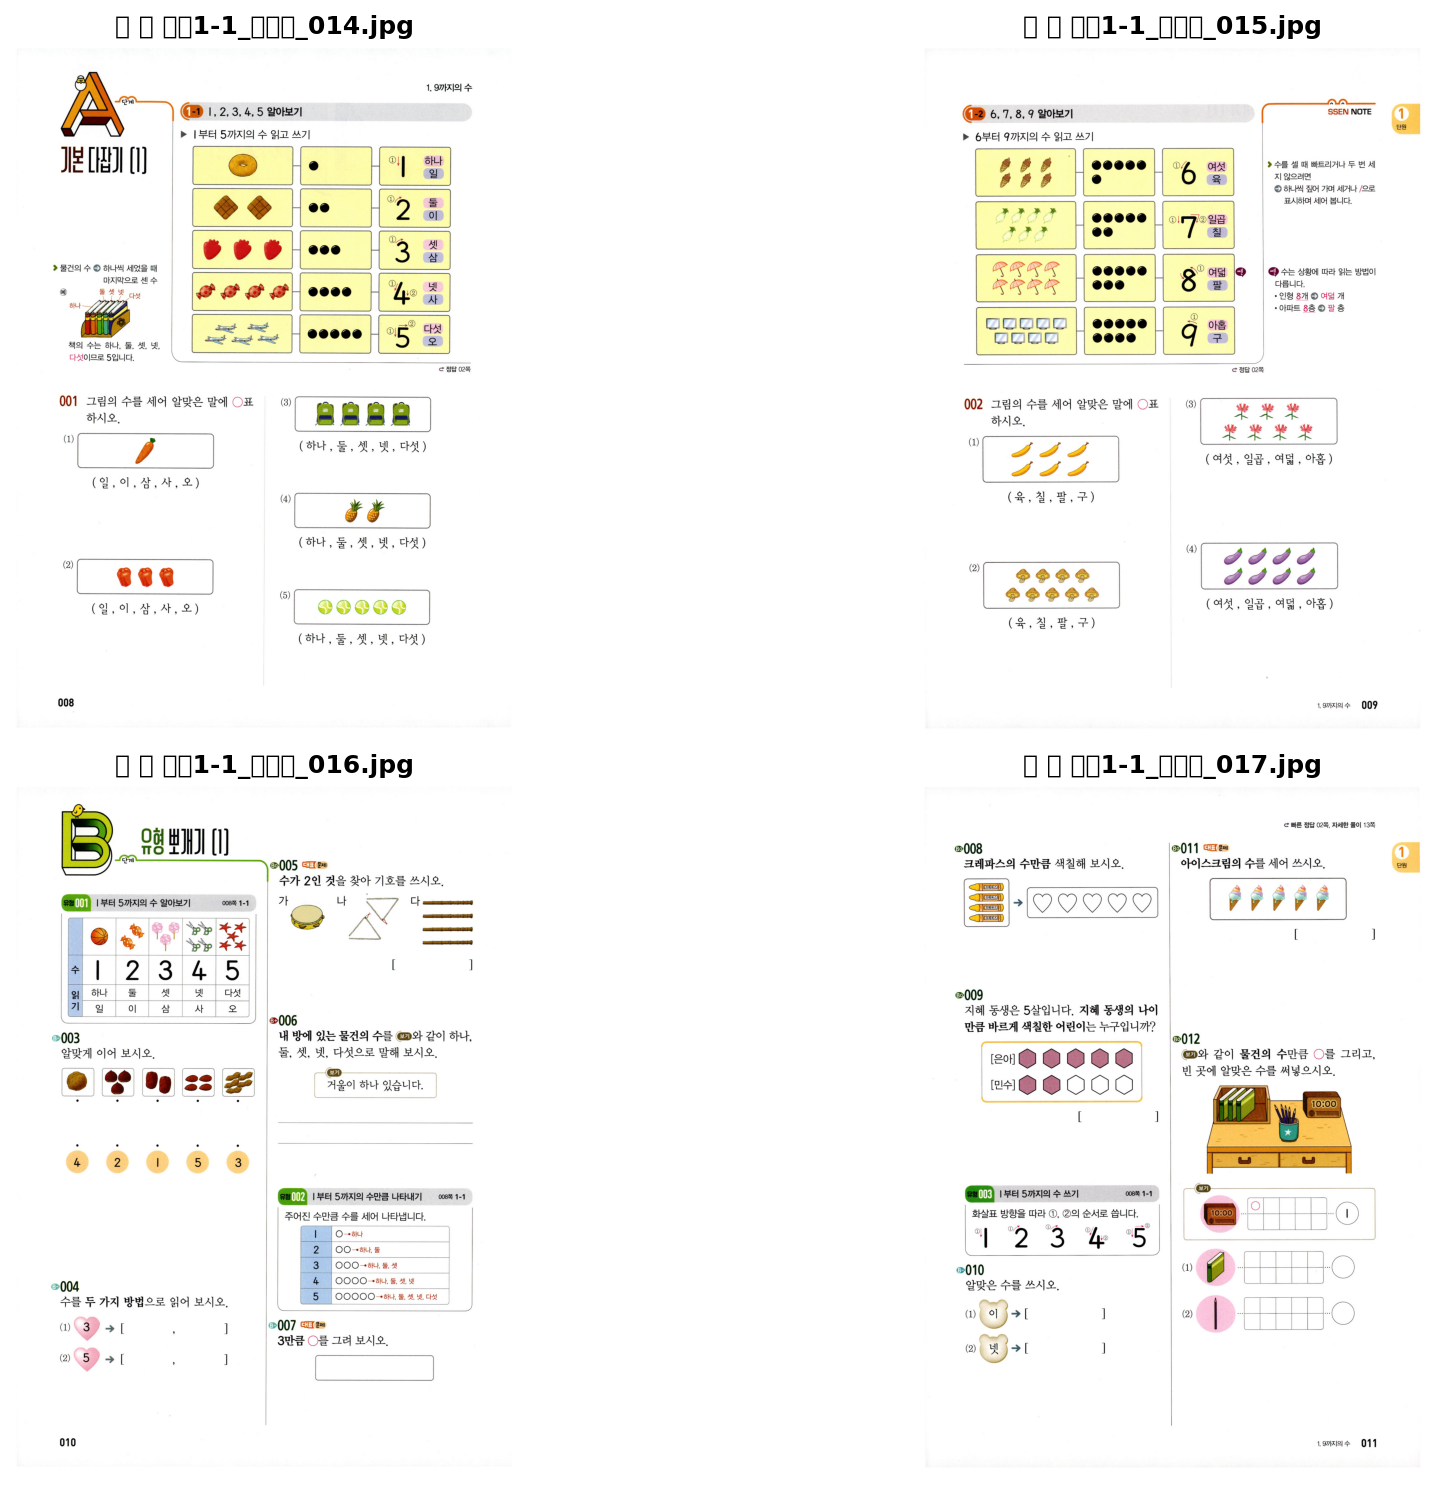

2025-06-04 12:19:56.135 | INFO     | __main__:upload_and_prepare_images:50 - 📋 미리보기: 4개 표시 (총 32개 이미지)



📥 docstructbench 모델 다운로드 중...


2025-06-04 12:19:56.533 | INFO     | __main__:download_model:26 - 📥 모델 다운로드: 학습지/교과서 최적화 모델
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)clayout_yolo_docstructbench_imgsz1024.pt:   0%|          | 0.00/40.7M [00:00<?, ?B/s]

2025-06-04 12:19:58.139 | INFO     | __main__:download_model:31 - ✅ 다운로드 완료: /root/.cache/huggingface/hub/models--juliozhao--DocLayout-YOLO-DocStructBench/snapshots/8c3299a30b8ff29a1503c4431b035b93220f7b11/doclayout_yolo_docstructbench_imgsz1024.pt
2025-06-04 12:20:03.927 | INFO     | __main__:load_model:43 - 🖥️ 사용 디바이스: cuda:0
2025-06-04 12:20:04.409 | INFO     | __main__:analyze_multiple_layouts:75 - 🔍 다중 이미지 레이아웃 분석 시작: 32개 이미지
2025-06-04 12:20:04.410 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [1/32] 처리 중: 쎈 수학1-1_페이지_014.jpg
2025-06-04 12:20:04.411 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_014.jpg



🔍 다중 이미지 레이아웃 분석 중... (32개)

image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_014.jpg: 1024x768 2 titles, 11 plain texts, 3 abandons, 7 figures, 156.4ms
Speed: 19.8ms preprocess, 156.4ms inference, 384.4ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:06.295 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 23개 영역, 4개 클래스
2025-06-04 12:20:06.295 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:06.296 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 23개 객체 감지
2025-06-04 12:20:06.297 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [2/32] 처리 중: 쎈 수학1-1_페이지_015.jpg
2025-06-04 12:20:06.298 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_015.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_015.jpg: 1024x768 2 titles, 11 plain texts, 3 abandons, 4 figures, 1 figure_caption, 110.9ms
Speed: 9.3ms preprocess, 110.9ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:06.562 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 21개 영역, 5개 클래스
2025-06-04 12:20:06.564 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'figure_caption', 'plain text', 'title']
2025-06-04 12:20:06.564 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 21개 객체 감지
2025-06-04 12:20:06.566 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [3/32] 처리 중: 쎈 수학1-1_페이지_016.jpg
2025-06-04 12:20:06.566 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_016.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_016.jpg: 1024x768 6 titles, 8 plain texts, 3 abandons, 9 figures, 2 tables, 110.8ms
Speed: 6.9ms preprocess, 110.8ms inference, 3.4ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:06.807 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 28개 영역, 5개 클래스
2025-06-04 12:20:06.809 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'table', 'title']
2025-06-04 12:20:06.811 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 28개 객체 감지
2025-06-04 12:20:06.813 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [4/32] 처리 중: 쎈 수학1-1_페이지_017.jpg
2025-06-04 12:20:06.814 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_017.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_017.jpg: 1024x768 5 titles, 11 plain texts, 4 abandons, 10 figures, 93.8ms
Speed: 10.0ms preprocess, 93.8ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:07.082 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 30개 영역, 4개 클래스
2025-06-04 12:20:07.083 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:07.084 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 30개 객체 감지
2025-06-04 12:20:07.084 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [5/32] 처리 중: 쎈 수학1-1_페이지_018.jpg
2025-06-04 12:20:07.085 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_018.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_018.jpg: 1024x768 4 titles, 7 plain texts, 3 abandons, 7 figures, 82.3ms
Speed: 9.7ms preprocess, 82.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:07.289 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 21개 영역, 4개 클래스
2025-06-04 12:20:07.290 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:07.291 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 21개 객체 감지
2025-06-04 12:20:07.292 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [6/32] 처리 중: 쎈 수학1-1_페이지_019.jpg
2025-06-04 12:20:07.292 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_019.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_019.jpg: 1024x768 5 titles, 15 plain texts, 3 abandons, 10 figures, 1 table, 80.5ms
Speed: 6.9ms preprocess, 80.5ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:07.500 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 34개 영역, 5개 클래스
2025-06-04 12:20:07.501 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'table', 'title']
2025-06-04 12:20:07.502 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 34개 객체 감지
2025-06-04 12:20:07.506 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [7/32] 처리 중: 쎈 수학1-1_페이지_020.jpg
2025-06-04 12:20:07.506 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_020.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_020.jpg: 1024x768 10 titles, 16 plain texts, 4 abandons, 9 figures, 79.8ms
Speed: 10.8ms preprocess, 79.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:07.709 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 39개 영역, 4개 클래스
2025-06-04 12:20:07.710 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:07.710 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 39개 객체 감지
2025-06-04 12:20:07.711 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [8/32] 처리 중: 쎈 수학1-1_페이지_021.jpg
2025-06-04 12:20:07.712 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_021.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_021.jpg: 1024x768 8 titles, 14 plain texts, 6 abandons, 7 figures, 79.6ms
Speed: 6.9ms preprocess, 79.6ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:07.921 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 35개 영역, 4개 클래스
2025-06-04 12:20:07.922 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:07.922 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 35개 객체 감지
2025-06-04 12:20:07.923 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [9/32] 처리 중: 쎈 수학1-1_페이지_022.jpg
2025-06-04 12:20:07.924 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_022.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_022.jpg: 1024x768 6 titles, 15 plain texts, 3 abandons, 9 figures, 79.7ms
Speed: 7.4ms preprocess, 79.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:08.145 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 33개 영역, 4개 클래스
2025-06-04 12:20:08.148 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:08.150 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 33개 객체 감지
2025-06-04 12:20:08.152 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [10/32] 처리 중: 쎈 수학1-1_페이지_023.jpg
2025-06-04 12:20:08.153 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_023.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_023.jpg: 1024x768 3 titles, 11 plain texts, 4 abandons, 5 figures, 1 table, 79.6ms
Speed: 6.8ms preprocess, 79.6ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:08.351 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 24개 영역, 5개 클래스
2025-06-04 12:20:08.351 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'table', 'title']
2025-06-04 12:20:08.352 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 24개 객체 감지
2025-06-04 12:20:08.353 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [11/32] 처리 중: 쎈 수학1-1_페이지_024.jpg
2025-06-04 12:20:08.353 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_024.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_024.jpg: 1024x768 3 titles, 7 plain texts, 3 abandons, 12 figures, 79.6ms
Speed: 8.5ms preprocess, 79.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:08.556 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 25개 영역, 4개 클래스
2025-06-04 12:20:08.557 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:08.558 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 25개 객체 감지
2025-06-04 12:20:08.558 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [12/32] 처리 중: 쎈 수학1-1_페이지_025.jpg
2025-06-04 12:20:08.559 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_025.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_025.jpg: 1024x768 4 titles, 10 plain texts, 6 abandons, 6 figures, 79.6ms
Speed: 6.8ms preprocess, 79.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:08.760 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 26개 영역, 4개 클래스
2025-06-04 12:20:08.761 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:08.761 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 26개 객체 감지
2025-06-04 12:20:08.762 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [13/32] 처리 중: 쎈 수학1-1_페이지_026.jpg
2025-06-04 12:20:08.762 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_026.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_026.jpg: 1024x768 5 titles, 15 plain texts, 3 abandons, 8 figures, 79.6ms
Speed: 7.1ms preprocess, 79.6ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:08.968 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 31개 영역, 4개 클래스
2025-06-04 12:20:08.971 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:08.973 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 31개 객체 감지
2025-06-04 12:20:08.975 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [14/32] 처리 중: 쎈 수학1-1_페이지_027.jpg
2025-06-04 12:20:08.976 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_027.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_027.jpg: 1024x768 6 titles, 11 plain texts, 3 abandons, 7 figures, 2 tables, 79.7ms
Speed: 9.1ms preprocess, 79.7ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:09.190 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 29개 영역, 5개 클래스
2025-06-04 12:20:09.191 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'table', 'title']
2025-06-04 12:20:09.192 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 29개 객체 감지
2025-06-04 12:20:09.192 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [15/32] 처리 중: 쎈 수학1-1_페이지_028.jpg
2025-06-04 12:20:09.193 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_028.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_028.jpg: 1024x768 5 titles, 9 plain texts, 2 abandons, 8 figures, 81.5ms
Speed: 8.3ms preprocess, 81.5ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:09.396 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 24개 영역, 4개 클래스
2025-06-04 12:20:09.397 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:09.398 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 24개 객체 감지
2025-06-04 12:20:09.398 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [16/32] 처리 중: 쎈 수학1-1_페이지_029.jpg
2025-06-04 12:20:09.399 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_029.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_029.jpg: 1024x768 5 titles, 10 plain texts, 4 abandons, 8 figures, 80.5ms
Speed: 6.9ms preprocess, 80.5ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:09.606 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 27개 영역, 4개 클래스
2025-06-04 12:20:09.607 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:09.608 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 27개 객체 감지
2025-06-04 12:20:09.609 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [17/32] 처리 중: 쎈 수학1-1_페이지_030.jpg
2025-06-04 12:20:09.609 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_030.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_030.jpg: 1024x768 7 titles, 17 plain texts, 4 abandons, 4 figures, 80.1ms
Speed: 8.5ms preprocess, 80.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:09.815 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 32개 영역, 4개 클래스
2025-06-04 12:20:09.817 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:09.818 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 32개 객체 감지
2025-06-04 12:20:09.818 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [18/32] 처리 중: 쎈 수학1-1_페이지_031.jpg
2025-06-04 12:20:09.819 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_031.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_031.jpg: 1024x768 2 titles, 13 plain texts, 5 abandons, 9 figures, 79.3ms
Speed: 8.7ms preprocess, 79.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:10.022 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 29개 영역, 4개 클래스
2025-06-04 12:20:10.023 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:10.024 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 29개 객체 감지
2025-06-04 12:20:10.025 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [19/32] 처리 중: 쎈 수학1-1_페이지_032.jpg
2025-06-04 12:20:10.026 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_032.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_032.jpg: 1024x768 3 titles, 16 plain texts, 4 abandons, 6 figures, 78.3ms
Speed: 6.9ms preprocess, 78.3ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:10.241 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 29개 영역, 4개 클래스
2025-06-04 12:20:10.244 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:10.245 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 29개 객체 감지
2025-06-04 12:20:10.245 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [20/32] 처리 중: 쎈 수학1-1_페이지_033.jpg
2025-06-04 12:20:10.246 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_033.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_033.jpg: 1024x768 6 titles, 12 plain texts, 6 abandons, 8 figures, 78.3ms
Speed: 7.0ms preprocess, 78.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:10.450 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 32개 영역, 4개 클래스
2025-06-04 12:20:10.453 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:10.453 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 32개 객체 감지
2025-06-04 12:20:10.454 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [21/32] 처리 중: 쎈 수학1-1_페이지_034.jpg
2025-06-04 12:20:10.455 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_034.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_034.jpg: 1024x768 8 titles, 14 plain texts, 2 abandons, 8 figures, 78.3ms
Speed: 8.5ms preprocess, 78.3ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:10.655 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 32개 영역, 4개 클래스
2025-06-04 12:20:10.658 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:10.660 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 32개 객체 감지
2025-06-04 12:20:10.662 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [22/32] 처리 중: 쎈 수학1-1_페이지_035.jpg
2025-06-04 12:20:10.663 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_035.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_035.jpg: 1024x768 5 titles, 18 plain texts, 3 abandons, 7 figures, 78.3ms
Speed: 7.5ms preprocess, 78.3ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:10.867 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 33개 영역, 4개 클래스
2025-06-04 12:20:10.868 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:10.868 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 33개 객체 감지
2025-06-04 12:20:10.869 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [23/32] 처리 중: 쎈 수학1-1_페이지_036.jpg
2025-06-04 12:20:10.869 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_036.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_036.jpg: 1024x768 6 titles, 13 plain texts, 2 abandons, 7 figures, 1 table, 78.3ms
Speed: 8.0ms preprocess, 78.3ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:11.077 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 29개 영역, 5개 클래스
2025-06-04 12:20:11.078 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'table', 'title']
2025-06-04 12:20:11.078 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 29개 객체 감지
2025-06-04 12:20:11.079 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [24/32] 처리 중: 쎈 수학1-1_페이지_037.jpg
2025-06-04 12:20:11.079 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_037.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_037.jpg: 1024x768 6 titles, 13 plain texts, 4 abandons, 12 figures, 2 figure_captions, 78.3ms
Speed: 7.8ms preprocess, 78.3ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:11.301 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 37개 영역, 5개 클래스
2025-06-04 12:20:11.302 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'figure_caption', 'plain text', 'title']
2025-06-04 12:20:11.302 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 37개 객체 감지
2025-06-04 12:20:11.303 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [25/32] 처리 중: 쎈 수학1-1_페이지_038.jpg
2025-06-04 12:20:11.303 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_038.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_038.jpg: 1024x768 5 titles, 13 plain texts, 2 abandons, 7 figures, 79.0ms
Speed: 7.1ms preprocess, 79.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:11.516 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 27개 영역, 4개 클래스
2025-06-04 12:20:11.517 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:11.518 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 27개 객체 감지
2025-06-04 12:20:11.520 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [26/32] 처리 중: 쎈 수학1-1_페이지_039.jpg
2025-06-04 12:20:11.524 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_039.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_039.jpg: 1024x768 4 titles, 19 plain texts, 4 abandons, 6 figures, 79.0ms
Speed: 7.1ms preprocess, 79.0ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:11.728 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 33개 영역, 4개 클래스
2025-06-04 12:20:11.731 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:11.732 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 33개 객체 감지
2025-06-04 12:20:11.732 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [27/32] 처리 중: 쎈 수학1-1_페이지_040.jpg
2025-06-04 12:20:11.734 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_040.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_040.jpg: 1024x768 4 titles, 17 plain texts, 4 abandons, 4 figures, 75.0ms
Speed: 6.8ms preprocess, 75.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:11.929 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 29개 영역, 4개 클래스
2025-06-04 12:20:11.930 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:11.931 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 29개 객체 감지
2025-06-04 12:20:11.931 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [28/32] 처리 중: 쎈 수학1-1_페이지_041.jpg
2025-06-04 12:20:11.932 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_041.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_041.jpg: 1024x768 4 titles, 17 plain texts, 5 abandons, 8 figures, 75.0ms
Speed: 9.6ms preprocess, 75.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:12.131 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 34개 영역, 4개 클래스
2025-06-04 12:20:12.132 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:12.133 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 34개 객체 감지
2025-06-04 12:20:12.134 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [29/32] 처리 중: 쎈 수학1-1_페이지_042.jpg
2025-06-04 12:20:12.134 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_042.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_042.jpg: 1024x768 3 titles, 11 plain texts, 3 abandons, 3 figures, 74.7ms
Speed: 6.8ms preprocess, 74.7ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:12.347 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 20개 영역, 4개 클래스
2025-06-04 12:20:12.348 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:12.348 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 20개 객체 감지
2025-06-04 12:20:12.349 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [30/32] 처리 중: 쎈 수학1-1_페이지_043.jpg
2025-06-04 12:20:12.349 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_043.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_043.jpg: 1024x768 2 titles, 12 plain texts, 4 abandons, 2 figures, 1 table, 74.9ms
Speed: 9.5ms preprocess, 74.9ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:12.551 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 21개 영역, 5개 클래스
2025-06-04 12:20:12.553 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'table', 'title']
2025-06-04 12:20:12.554 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 21개 객체 감지
2025-06-04 12:20:12.556 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [31/32] 처리 중: 쎈 수학1-1_페이지_044.jpg
2025-06-04 12:20:12.557 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_044.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_044.jpg: 1024x768 4 titles, 9 plain texts, 2 abandons, 3 figures, 74.9ms
Speed: 7.1ms preprocess, 74.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:12.751 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 18개 영역, 4개 클래스
2025-06-04 12:20:12.752 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'figure', 'plain text', 'title']
2025-06-04 12:20:12.753 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 18개 객체 감지
2025-06-04 12:20:12.754 | INFO     | __main__:analyze_multiple_layouts:82 - 📄 [32/32] 처리 중: 쎈 수학1-1_페이지_045.jpg
2025-06-04 12:20:12.755 | INFO     | __main__:analyze_layout:3 - 🔍 레이아웃 분석 시작: 쎈 수학1-1_페이지_045.jpg



image 1/1 /content/DocLayout-YOLO/쎈 수학1-1_페이지_045.jpg: 1024x768 3 titles, 7 plain texts, 4 abandons, 74.7ms
Speed: 8.2ms preprocess, 74.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 768)


2025-06-04 12:20:12.952 | INFO     | __main__:analyze_layout:64 - ✅ 분석 완료: 14개 영역, 3개 클래스
2025-06-04 12:20:12.954 | INFO     | __main__:analyze_layout:65 - 🏷️ 감지된 클래스: ['abandon', 'plain text', 'title']
2025-06-04 12:20:12.957 | INFO     | __main__:analyze_multiple_layouts:101 - ✅ 완료: 14개 객체 감지
2025-06-04 12:20:12.958 | INFO     | __main__:analyze_multiple_layouts:109 - 📊 전체 결과: 899개 객체, 6개 클래스
2025-06-04 12:20:12.959 | INFO     | __main__:merge_overlapping_boxes:115 - 🔧 겹치는 박스 통합 중...
2025-06-04 12:20:12.961 | INFO     | __main__:merge_overlapping_boxes:194 - 🔧 통합 완료: 23 → 23개
2025-06-04 12:20:12.962 | INFO     | __main__:merge_overlapping_boxes:115 - 🔧 겹치는 박스 통합 중...
2025-06-04 12:20:12.963 | INFO     | __main__:merge_overlapping_boxes:194 - 🔧 통합 완료: 21 → 19개
2025-06-04 12:20:12.965 | INFO     | __main__:merge_overlapping_boxes:115 - 🔧 겹치는 박스 통합 중...
2025-06-04 12:20:12.967 | INFO     | __main__:merge_overlapping_boxes:194 - 🔧 통합 완료: 28 → 26개
2025-06-04 12:20:12.968 | INFO     | __ma

🔧 겹치는 박스 통합 중...
🎨 결과 시각화 중...


<ipython-input-6-03c22c690ed5>:177: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03c22c690ed5>:177: UserWarning: Glyph 50056 (\N{HANGUL SYLLABLE SSEN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03c22c690ed5>:177: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03c22c690ed5>:177: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03c22c690ed5>:177: UserWarning: Glyph 54168 (\N{HANGUL SYLLABLE PE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03c22c690ed5>:177: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03c22c690ed5>:177: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input

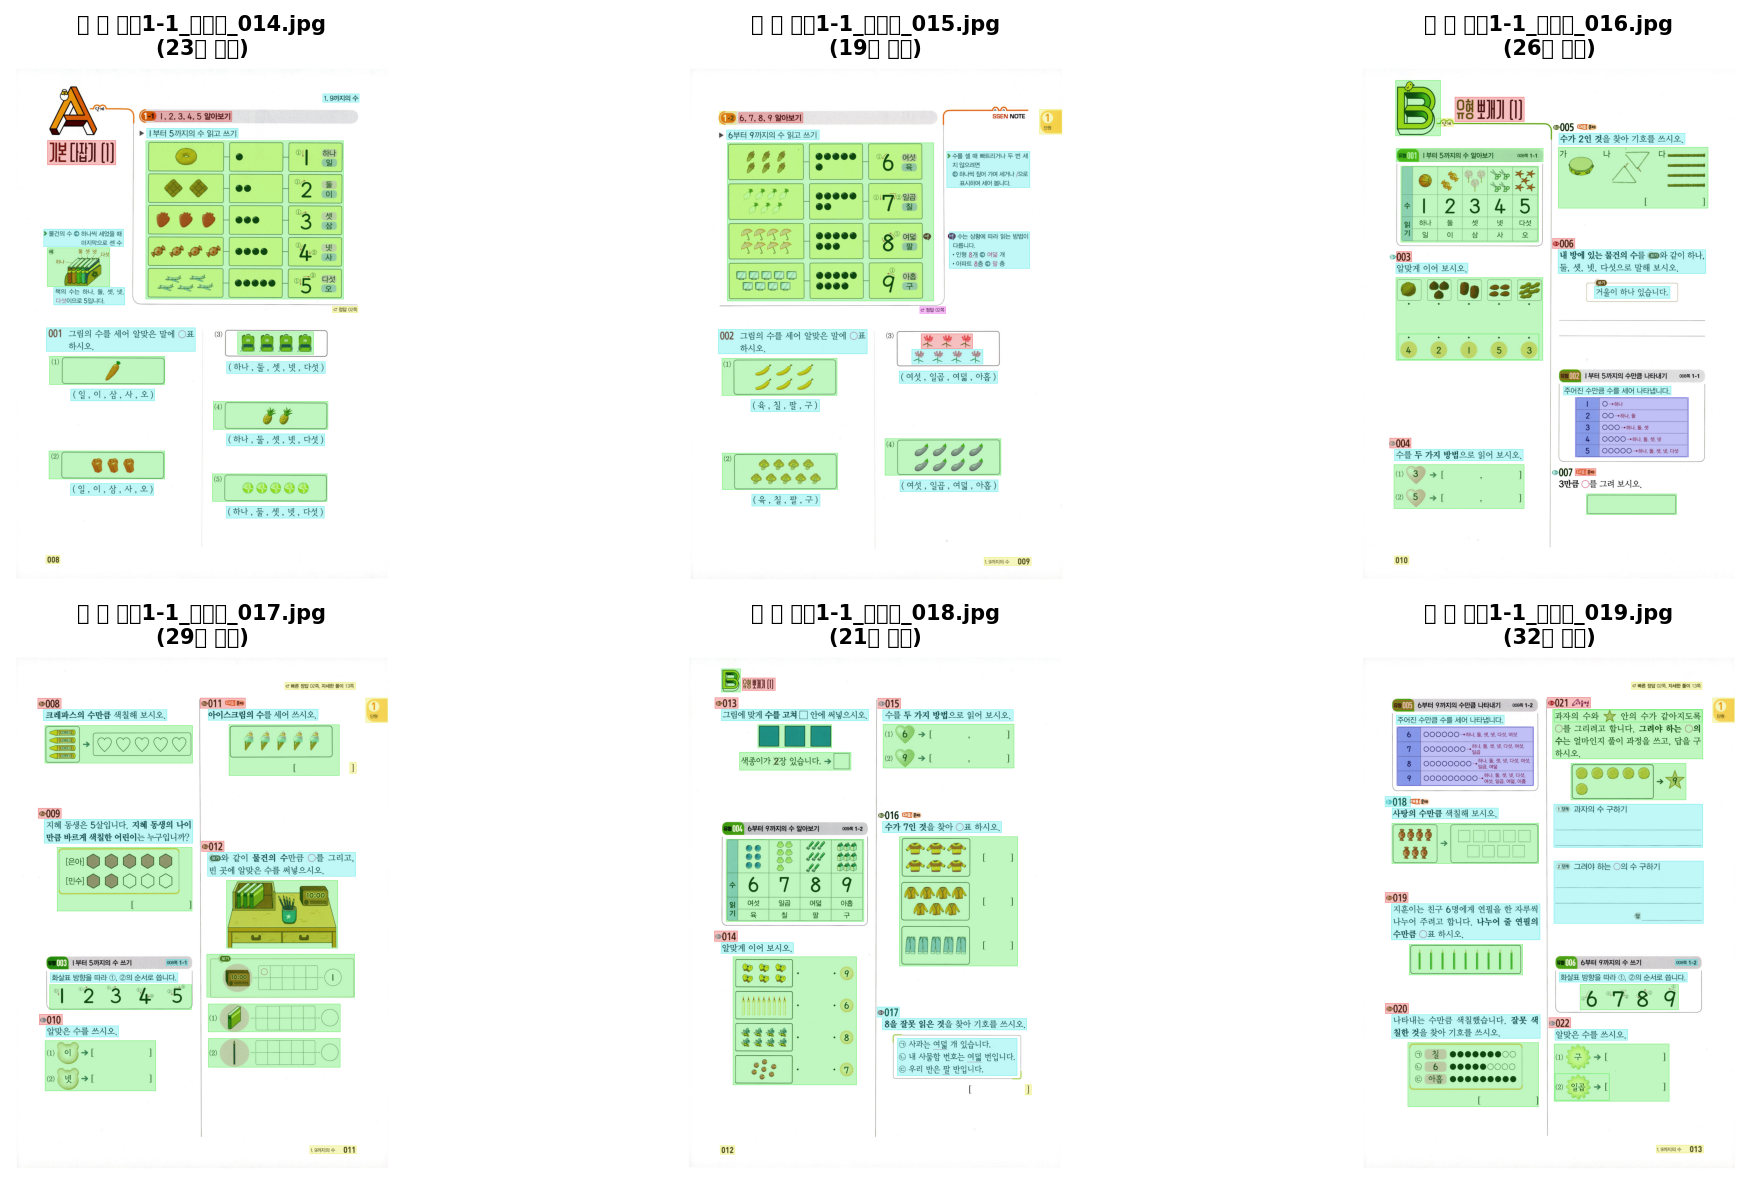

2025-06-04 12:20:21.170 | INFO     | __main__:visualize_multiple_layouts:197 - 🎨 다중 이미지 시각화 완료
2025-06-04 12:20:21.175 | INFO     | __main__:export_to_cvat:261 - 📤 CVAT 변환 시작...
2025-06-04 12:20:21.176 | INFO     | __main__:create_cvat_labels_file:10 - 📄 CVAT 레이블 파일 생성: cvat_export/cvat_labels.txt (6개 클래스)
2025-06-04 12:20:21.177 | INFO     | __main__:convert_to_coco_json:15 - 📄 COCO JSON 변환 중...
2025-06-04 12:20:21.208 | INFO     | __main__:convert_to_coco_json:95 - 📄 COCO JSON 변환 완료: cvat_export/layout_results_coco.json (858개 어노테이션)
2025-06-04 12:20:21.209 | INFO     | __main__:convert_to_cvat_xml_v11:100 - 📄 CVAT 1.1 XML 변환 중...
2025-06-04 12:20:21.277 | INFO     | __main__:convert_to_cvat_xml_v11:184 - 📄 CVAT 1.1 XML 변환 완료: cvat_export/layout_results_cvat_v11.xml



📊 다중 이미지 레이아웃 분석 통계:
📋 처리된 이미지: 32개
📈 총 객체 수: 858개
🎯 고유 클래스: 6개

🏷️ 클래스별 통계:
  plain text               : 379개
  figure                   : 205개
  title                    : 148개
  abandon                  : 115개
  table                    :   8개
  figure_caption           :   3개

📋 이미지별 통계:
  쎈 수학1-1_페이지_014.jpg           :  23개 객체
  쎈 수학1-1_페이지_015.jpg           :  19개 객체
  쎈 수학1-1_페이지_016.jpg           :  26개 객체
  쎈 수학1-1_페이지_017.jpg           :  29개 객체
  쎈 수학1-1_페이지_018.jpg           :  21개 객체
  쎈 수학1-1_페이지_019.jpg           :  32개 객체
  쎈 수학1-1_페이지_020.jpg           :  38개 객체
  쎈 수학1-1_페이지_021.jpg           :  35개 객체
  쎈 수학1-1_페이지_022.jpg           :  32개 객체
  쎈 수학1-1_페이지_023.jpg           :  22개 객체
  쎈 수학1-1_페이지_024.jpg           :  24개 객체
  쎈 수학1-1_페이지_025.jpg           :  24개 객체
  쎈 수학1-1_페이지_026.jpg           :  29개 객체
  쎈 수학1-1_페이지_027.jpg           :  28개 객체
  쎈 수학1-1_페이지_028.jpg           :  23개 객체
  쎈 수학1-1_페이지_029.jpg           :  25개 객체
  쎈 수학1-1_페이지_030.jpg           : 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 다운로드: layout_results_cvat_v11.xml


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 다운로드: layout_results_coco.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 다운로드: README.md


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 다운로드: cvat_labels.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 다운로드: images_list.txt

🎉 분석 완료!
⏱️ 처리 시간: 150.37초
📋 처리된 이미지: 32개
📊 감지된 객체: 858개
🏷️ 고유 클래스: 6개
📤 CVAT 어노테이션: 858개
💾 결과 파일: layout_analysis_results_multi_20250604_122021.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2025-06-04 12:20:21.348 | INFO     | __main__:analyze_layout_and_export_to_cvat:147 - ✅ 전체 프로세스 완료


📥 결과 파일 다운로드: layout_analysis_results_multi_20250604_122021.json

🎉 다중 이미지 처리 완료!
📷 처리된 이미지: 32개
🎯 총 객체 수: 858개
🏷️ 고유 클래스: 6개
⏱️ 처리 시간: 150.37초

📤 CVAT 파일 생성 완료:
  📁 출력 폴더: cvat_export
  📄 COCO JSON: layout_results_coco.json
  📄 CVAT 1.1 XML: layout_results_cvat_v11.xml
  📋 이미지 목록: images_list.txt
  🏷️ 레이블 파일: cvat_labels.txt

📊 이미지별 결과:
  📄 쎈 수학1-1_페이지_014.jpg: 23개 객체 (title, figure, abandon 등 4개)
  📄 쎈 수학1-1_페이지_015.jpg: 19개 객체 (title, abandon, figure 등 5개)
  📄 쎈 수학1-1_페이지_016.jpg: 26개 객체 (title, abandon, plain text 등 5개)
  📄 쎈 수학1-1_페이지_017.jpg: 29개 객체 (title, plain text, abandon 등 4개)
  📄 쎈 수학1-1_페이지_018.jpg: 21개 객체 (title, figure, abandon 등 4개)
  📄 쎈 수학1-1_페이지_019.jpg: 32개 객체 (title, abandon, plain text 등 5개)
  📄 쎈 수학1-1_페이지_020.jpg: 38개 객체 (title, figure, abandon 등 4개)
  📄 쎈 수학1-1_페이지_021.jpg: 35개 객체 (title, plain text, abandon 등 4개)
  📄 쎈 수학1-1_페이지_022.jpg: 32개 객체 (title, plain text, abandon 등 4개)
  📄 쎈 수학1-1_페이지_023.jpg: 22개 객체 (title, abandon, plain text 등 5개)
  📄 쎈 수학1-1_페이지_

In [ ]:
# 🆕 다중 이미지 모드 데모 실행
# 여러 이미지를 처리하여 하나의 CVAT 파일로 생성합니다

print("🆕 다중 이미지 모드 데모")
print("💡 여러 이미지를 선택하여 업로드하세요.")
print("🎯 모든 이미지가 하나의 CVAT 프로젝트로 통합됩니다.")

results = analyze_layout_and_export_to_cvat(
    model_choice="docstructbench",     # 학습지/교과서에 최적화된 모델
    enable_cvat_export=True,          # CVAT 변환 활성화
    merge_boxes=True,                 # 겹치는 박스 통합
    iou_threshold=0.3,                # IoU 임계값
    multiple_images=True              # 🆕 다중 이미지 모드 활성화
)

# 결과 출력
if results and results['multiple_images']:
    print("\n🎉 다중 이미지 처리 완료!")
    print("=" * 60)
    print(f"📷 처리된 이미지: {results['statistics']['total_images']}개")
    print(f"🎯 총 객체 수: {results['statistics']['total_objects']}개")
    print(f"🏷️ 고유 클래스: {results['statistics']['unique_classes']}개")
    print(f"⏱️ 처리 시간: {results['statistics']['processing_time']:.2f}초")

    if results.get('cvat_results'):
        print(f"\n📤 CVAT 파일 생성 완료:")
        print(f"  📁 출력 폴더: {results['cvat_results']['output_dir']}")
        print(f"  📄 COCO JSON: layout_results_coco.json")
        print(f"  📄 CVAT 1.1 XML: layout_results_cvat_v11.xml")
        print(f"  📋 이미지 목록: images_list.txt")
        print(f"  🏷️ 레이블 파일: cvat_labels.txt")

    print(f"\n📊 이미지별 결과:")
    for img_stat in results['statistics']['images_breakdown']:
        classes_str = ', '.join(img_stat['classes'][:3])  # 처음 3개 클래스만 표시
        if len(img_stat['classes']) > 3:
            classes_str += f" 등 {len(img_stat['classes'])}개"
        print(f"  📄 {img_stat['name']}: {img_stat['objects_count']}개 객체 ({classes_str})")

    print("\n💡 CVAT 사용법:")
    print("1. CVAT에서 새 프로젝트 생성")
    print("2. images_list.txt 순서대로 이미지 업로드")
    print("3. cvat_labels.txt로 레이블 설정")
    print("4. layout_results_coco.json을 'COCO 1.0' 형식으로 import")
    print("5. 필요시 클래스명 수정 및 박스 조정")

else:
    print("❌ 다중 이미지 처리 실패 또는 단일 이미지 모드로 실행됨")